# Cell 1: Import Libraries

In [1]:

%run Evolutionary_NN_Search_CIFAR10_Params.ipynb


import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from deap import base, creator, tools, algorithms

# Enable inline plotting
%matplotlib inline


In [2]:

print(f'Using device: {DEVICE}')


Using device: cpu


# Cell 2: Data Loading and Preprocessing

Files already downloaded and verified


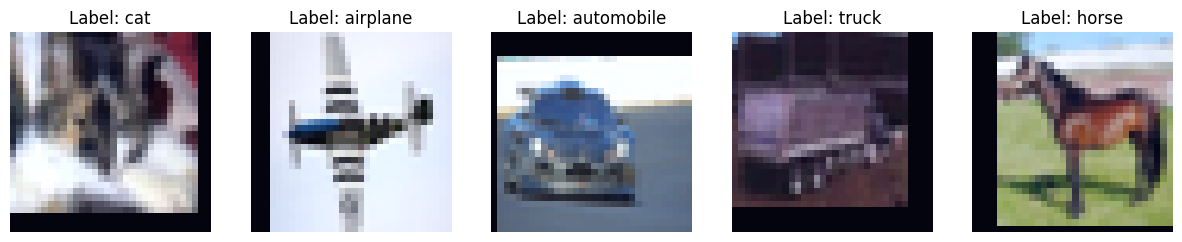

In [3]:

from torch.utils.data import random_split

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
        (0.2023, 0.1994, 0.2010)   # CIFAR-10 std
    )
])

# Load CIFAR-10 dataset
if DATASET == 'CIFAR10':
    full_dataset = datasets.CIFAR10(DATA_DIR, train=True, download=True, transform=transform)
else:
    raise ValueError(f"Dataset {DATASET} is not supported.")

# Reduce dataset size to simulate limited data
indices = list(range(len(full_dataset)))
random.shuffle(indices)
small_indices = indices[:SMALL_DATASET_SIZE]
small_dataset = torch.utils.data.Subset(full_dataset, small_indices)

# Split small_dataset into train and validation sets
train_size = int(TRAIN_VAL_SPLIT * len(small_dataset))
val_size = len(small_dataset) - train_size
train_subset, val_subset = random_split(small_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

val_loader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


def show_images(dataset, indices):
    classes = dataset.classes
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 4))
    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.2 + 0.5, 0, 1)  # Approximate denormalization
        ax.imshow(img)
        ax.set_title(f'Label: {classes[label]}')
        ax.axis('off')
    plt.show()

# Display first 5 images in the small dataset
sample_indices = small_indices[:5]
show_images(full_dataset, sample_indices)


# Cell 4: Define the Search Space and Evolutionary Algorithm Setup

In [4]:


# Cell 4: Define Evolutionary Algorithm Components

# Define individual and fitness classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Functions to generate random parameters
def generate_random_num_layers():
    return random.randint(MIN_LAYERS, MAX_LAYERS)

def generate_random_filters(num_layers):
    return [random.choice(NUM_FILTERS_OPTIONS) for _ in range(num_layers)]

def generate_random_kernel_sizes(num_layers):
    return [random.choice(KERNEL_SIZES) for _ in range(num_layers)]

def generate_random_activation():
    return random.choice(ACTIVATION_FUNCTIONS)

def generate_random_learning_rate():
    return 10 ** np.random.uniform(np.log10(LEARNING_RATE_MIN), np.log10(LEARNING_RATE_MAX))

# Function to create an individual
def create_individual():
    num_layers = random.randint(MIN_LAYERS, MAX_LAYERS)
    filters = []
    kernel_sizes = []
    for _ in range(num_layers):
        filters.append(random.choice(NUM_FILTERS_OPTIONS))
        kernel_sizes.append(random.choice(KERNEL_SIZES))
    activation = random.choice(ACTIVATION_FUNCTIONS)
    learning_rate = generate_random_learning_rate()
    return creator.Individual([filters, kernel_sizes, activation, learning_rate])


# Initialize the toolbox
toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Cell 5: Define the Evaluation Function

In [5]:
def evaluate_individual(individual):
    filters, kernel_sizes, activation_fn, learning_rate = individual

    # Debug: Print the individual's parameters
    print("Evaluating Individual:")
    print(f"  Filters: {filters}")
    print(f"  Kernel Sizes: {kernel_sizes}")
    print(f"  Activation Function: {activation_fn.__name__}")
    print(f"  Learning Rate: {learning_rate}")

    # Define the neural network architecture
    class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            layers = []
            input_channels = INPUT_CHANNELS
            current_height, current_width = 32, 32  # CIFAR-10 image size

            for idx, (out_channels, kernel_size) in enumerate(zip(filters, kernel_sizes)):
                # Convolutional layer
                layers.append(nn.Conv2d(input_channels, out_channels, kernel_size=kernel_size, padding=1))
                # Use InstanceNorm2d instead of BatchNorm2d
                layers.append(nn.InstanceNorm2d(out_channels))
                layers.append(activation_fn())

                # Update spatial dimensions after Conv2d
                current_height = self.compute_output_size(current_height, kernel_size, stride=1, padding=1)
                current_width = self.compute_output_size(current_width, kernel_size, stride=1, padding=1)

                # Add MaxPool2d if spatial dimensions are large enough
                if current_height >= 4 and current_width >= 4:
                    layers.append(nn.MaxPool2d(2))
                    current_height = self.compute_output_size(current_height, kernel_size=2, stride=2, padding=0)
                    current_width = self.compute_output_size(current_width, kernel_size=2, stride=2, padding=0)
                else:
                    print(f"  Skipping MaxPool2d at layer {idx+1} due to small spatial dimensions.")

                # Debug: Print the output size after each layer
                #print(f"  Layer {idx+1}:")
                ##print(f"    Output Channels: {out_channels}")
                #print(f"    Kernel Size: {kernel_size}")
                #print(f"    Current Height: {current_height}")
                #print(f"    Current Width: {current_width}")

                if current_height < 1 or current_width < 1:
                    raise ValueError(f"Spatial dimensions have become too small at layer {idx+1}.")

                input_channels = out_channels

            self.features = nn.Sequential(*layers)

            # Dynamically compute the flattened size
            with torch.no_grad():
                sample_input = torch.randn(1, INPUT_CHANNELS, 32, 32)
                sample_output = self.features(sample_input)
                flattened_size = sample_output.view(-1).shape[0]

                # Debug: Print the flattened size
                #print(f"  Flattened Size: {flattened_size}")

            self.classifier = nn.Linear(flattened_size, NUM_CLASSES)

        def compute_output_size(self, size, kernel_size, stride=1, padding=0):
            return int((size + 2 * padding - kernel_size) / stride + 1)

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

    try:
        # Initialize the network
        model = ConvNet().to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        epochs = EPOCHS
        model.train()
        for epoch in range(epochs):
            for data, target in train_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        # Evaluate accuracy on training data
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = correct / total

        # Debug: Print final accuracy
        print(f"  Training Accuracy: {accuracy:.4f}")

    except Exception as e:
        # If the model fails to train, assign a low fitness score
        print(f"Exception occurred during training: {e}")
        accuracy = 0.0
    return (accuracy, )


# Cell 6: Define Genetic Operators

In [6]:


def mutate_individual(individual):
    # Mutate number of layers, filters, and kernel sizes
    if random.random() < MUT_PROB:
        num_layers = generate_random_num_layers()
        individual[0] = generate_random_filters(num_layers)
        individual[1] = generate_random_kernel_sizes(num_layers)
    # Mutate activation function
    if random.random() < MUT_PROB:
        individual[2] = generate_random_activation()
    # Mutate learning rate
    if random.random() < MUT_PROB:
        individual[3] = generate_random_learning_rate()
    return individual,


def crossover_individuals(ind1, ind2):
    # Swap filters and kernel sizes
    if random.random() < CX_PROB:
        ind1[0], ind2[0] = ind2[0], ind1[0]
        ind1[1], ind2[1] = ind2[1], ind1[1]
    # Swap activation function
    if random.random() < CX_PROB:
        ind1[2], ind2[2] = ind2[2], ind1[2]
    # Swap learning rate
    if random.random() < CX_PROB:
        ind1[3], ind2[3] = ind2[3], ind1[3]
    return ind1, ind2

toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)


# Cell 7: Run the Evolutionary Algorithm


In [7]:

def run_evolution():
    population = toolbox.population(n=POPULATION_SIZE)

    # Statistics to keep track of progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # Run the evolutionary algorithm
    population, logbook = algorithms.eaSimple(
        population, toolbox,
        cxpb=CX_PROB, mutpb=MUT_PROB,
        ngen=NUM_GENERATIONS,
        stats=stats,
        verbose=True
    )
    return population, logbook

population, logbook = run_evolution()


Evaluating Individual:
  Filters: [16, 128, 32, 16]
  Kernel Sizes: [3, 3, 3, 3]
  Activation Function: ReLU
  Learning Rate: 0.00013292918943162154
  Training Accuracy: 0.2440
Evaluating Individual:
  Filters: [32, 16, 16, 64, 128]
  Kernel Sizes: [3, 3, 3, 3, 3]
  Activation Function: ReLU
  Learning Rate: 0.007114476009343417
  Skipping MaxPool2d at layer 5 due to small spatial dimensions.
  Training Accuracy: 0.3250
Evaluating Individual:
  Filters: [16, 32, 32, 32]
  Kernel Sizes: [3, 3, 3, 3]
  Activation Function: Tanh
  Learning Rate: 0.0015702970884055383
  Training Accuracy: 0.3230
Evaluating Individual:
  Filters: [128, 64, 128]
  Kernel Sizes: [3, 3, 3]
  Activation Function: Tanh
  Learning Rate: 0.0006251373574521746
  Training Accuracy: 0.3855
Evaluating Individual:
  Filters: [64, 64]
  Kernel Sizes: [3, 3]
  Activation Function: Tanh
  Learning Rate: 2.9380279387035327e-05
  Training Accuracy: 0.2233
Evaluating Individual:
  Filters: [32, 16]
  Kernel Sizes: [3, 3]
  A

KeyboardInterrupt: 

# Cell 8: Analyze Results

Best Individual:
Filters per Layer: [16, 64, 128, 128]
Kernel Sizes: [3, 3, 3, 5]
Activation Function: ReLU
Learning Rate: 0.000133
Fitness (Accuracy): 0.4662


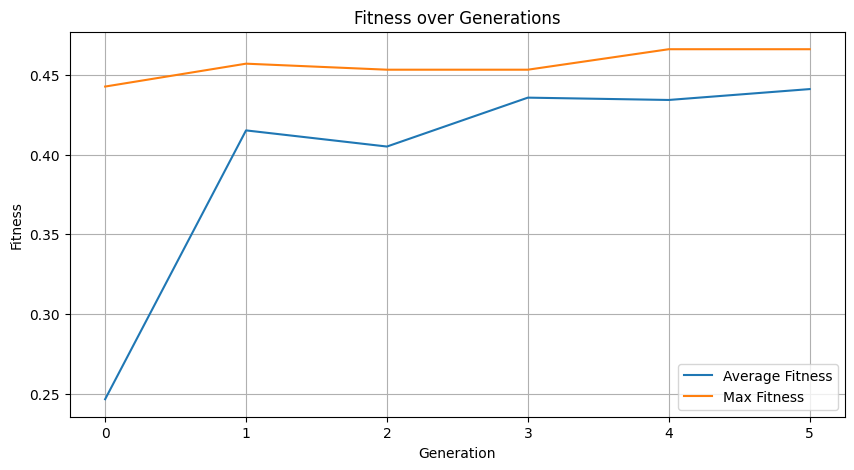

In [ ]:
# Cell 10: Analyze Results

# Find the best individual
top_individual = tools.selBest(population, k=1)[0]
filters, kernel_sizes, activation_fn, learning_rate = top_individual

print("Best Individual:")
print(f"Filters per Layer: {filters}")
print(f"Kernel Sizes: {kernel_sizes}")
print(f"Activation Function: {activation_fn.__name__}")
print(f"Learning Rate: {learning_rate:.6f}")
print(f"Fitness (Accuracy): {top_individual.fitness.values[0]:.4f}")

# Plot the evolution of fitness over generations
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")

plt.figure(figsize=(10, 5))
plt.plot(gen, avg_fitness, label='Average Fitness')
plt.plot(gen, max_fitness, label='Max Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()


# Cell 9: Visualize the Best Model's Performance

In [ ]:
# Cell 11: Retrain the Best Model

# Re-train the best model to see its performance
best_filters = filters
best_kernel_sizes = kernel_sizes
best_activation_fn = activation_fn
best_learning_rate = learning_rate

class BestConvNet(nn.Module):
    def __init__(self):
        super(BestConvNet, self).__init__()
        layers = []
        input_channels = INPUT_CHANNELS
        for out_channels, kernel_size in zip(best_filters, best_kernel_sizes):
            layers.append(nn.Conv2d(input_channels, out_channels, kernel_size=kernel_size, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(best_activation_fn())
            layers.append(nn.MaxPool2d(2))
            input_channels = out_channels
        self.features = nn.Sequential(*layers)
        
        # Dynamically compute the flattened size
        with torch.no_grad():
            sample_input = torch.randn(1, INPUT_CHANNELS, 32, 32)
            sample_output = self.features(sample_input)
            flattened_size = sample_output.view(-1).shape[0]
        
        self.classifier = nn.Linear(flattened_size, NUM_CLASSES)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the network
best_model = BestConvNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)

# Training loop
best_model.train()
for epoch in range(RETRAIN_EPOCHS):
    epoch_loss = 0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = best_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{RETRAIN_EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}')

# Evaluate on training data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
accuracy = correct / total
print(f'Training Accuracy: {accuracy:.4f}')




RuntimeError: mat1 and mat2 shapes cannot be multiplied (8192x1 and 128x10)

# Cell 10: Test on Validation Data (Optional)

In [ ]:
# Load test dataset
test_dataset = datasets.CIFAR10(DATA_DIR, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate on test data
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Files already downloaded and verified
Test Accuracy: 0.4155
